In [75]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import os
import math

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

#from pyramid.arima import auto_arima
#from pmdarima.arima import auto_arima
#!pip install pyflux
#import pyflux as pf

# Treditional forecating packages
# ==============================================================================
#from sklearn.cluster import KMeans
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
#!pip install pmdarima
from pmdarima.arima import auto_arima

# ML forecating packages
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#!pip install skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster



# Prophet
# ==============================================================================
#!pip install prophet
from prophet import Prophet


#!pip install tensorflow
#!pip install keras

#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


## Read data

In [37]:
df = pd.read_csv("energy.dat")
print("number of daily observations = ",df.shape[0])

#df.Date = pd.to_datetime(df.Date,format='%Y-%m-%d').dt.date
df['Date'] = pd.to_datetime(df.Date,format='%d-%b-%y')
df = df.set_index('Date')

df = df.asfreq('D')
#show some summart statstics for the data
df.describe()


number of daily observations =  1827


,Consumption
count,1827.000000
mean,257.885096
std,100.993368
min,82.675000
25%,174.672500
50%,242.719000
75%,327.841000
max,589.269000


* We have around 1827 daily observations which roughly equates to around 5 years worth of energy consumption for the UK

matplotlib.legend WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


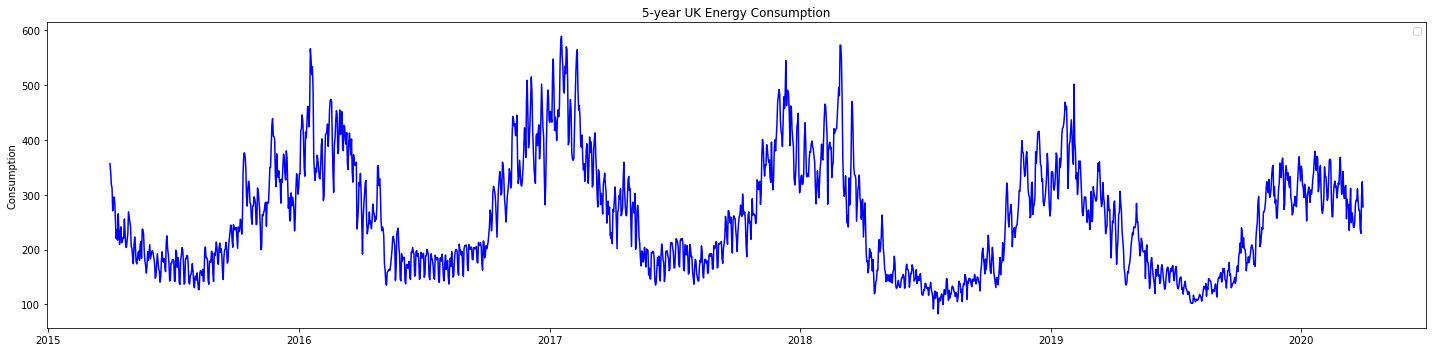

In [40]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(df.index, df.Consumption, color = 'blue')
#ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:pink')
ax1.set_ylabel('Consumption')
ax1.legend()
#ax2 = ax1.twinx()
#ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
#ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
#ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('5-year UK Energy Consumption')
fig.tight_layout()
plt.show()

* Clearly see a strong seasonal pattern in the consumptipn data, with higher usage in Q1 and Q4 as expected to coincide with Winter and Autumn months in the year and lower during Q2 and Q3 for spring and summer.  

## Define train and test split 
* As we looking to forecast one year in advance, it's a reasonable start to use Apr 2015 to Mar 2019 as training and Apr 2019 to Mar 2020 as the ut of sample testing period.

<AxesSubplot:xlabel='Date'>

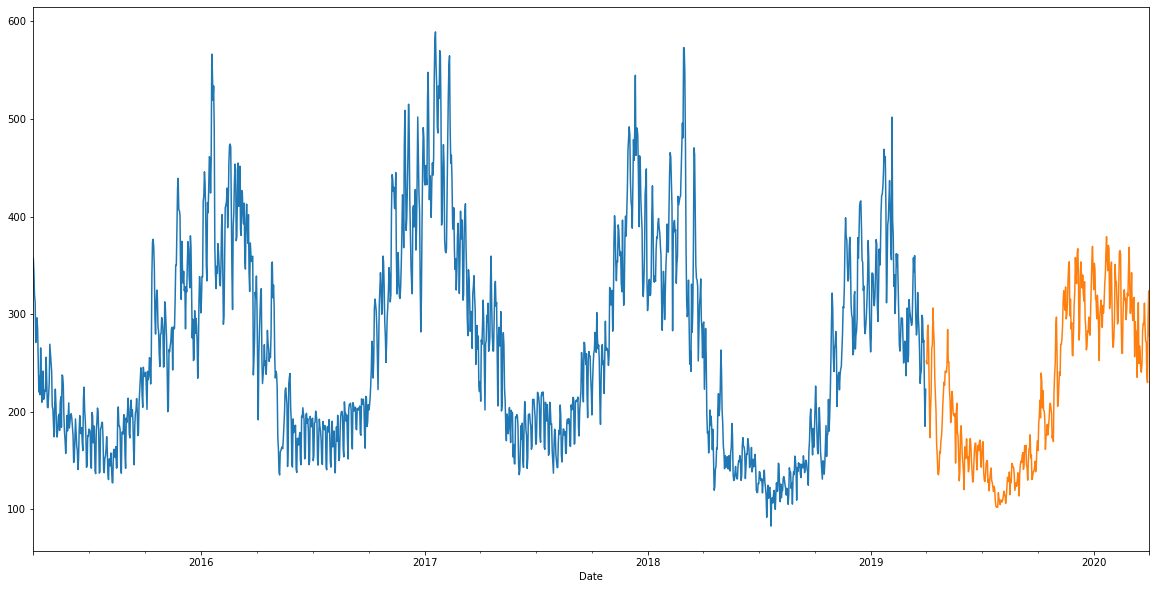

In [103]:
train = df.iloc[:(len(df)-366)]
test = df.iloc[len(train):]


train['Consumption'].plot(figsize=(20,10))
test['Consumption'].plot(figsize=(20,10))


# Plot the ACF

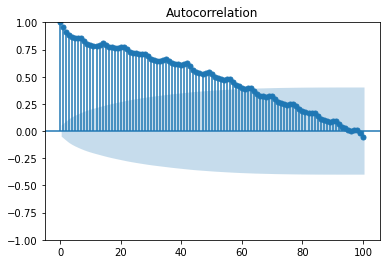

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


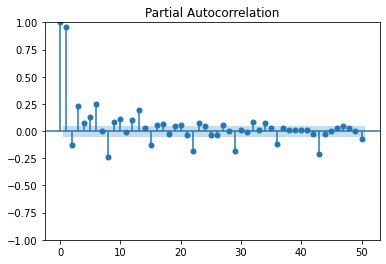

In [45]:
plot_acf(train.Consumption,lags=100)
plt.show()
plot_pacf(train.Consumption,lags=50)
plt.show()

* Autocorrelation plot shows gradual decay while  Partial AutoCorrelation shows that there is a sharp drop after 1st lag indicating a strong AR(1) component.
* Slow decay in the ACF is also an indication of a non-stationary process. 
* For a more concrete picture of non-stationary we perform the Dicky fuller test, where we see that the p-value is greater than 0.05 so we have non-stationarity. 

In [46]:
t = sm.tsa.adfuller(train.Consumption, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                   -2.347969
p-value                           0.156963
#Lags Used                       23.000000
Number of Observations Used    1437.000000
dtype: float64

In [47]:
# function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff


t  = sm.tsa.adfuller(difference(train.Consumption,1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])


Test Statistic                -9.598773e+00
p-value                        1.945898e-16
#Lags Used                     2.200000e+01
Number of Observations Used    1.437000e+03
dtype: float64

* Following differencing we see that the p-value is much less than 0.05 so we conclude we now have stationarity as we reject the unit route null hypothesis at the 95% level of significance.

## Seasonal decomposition

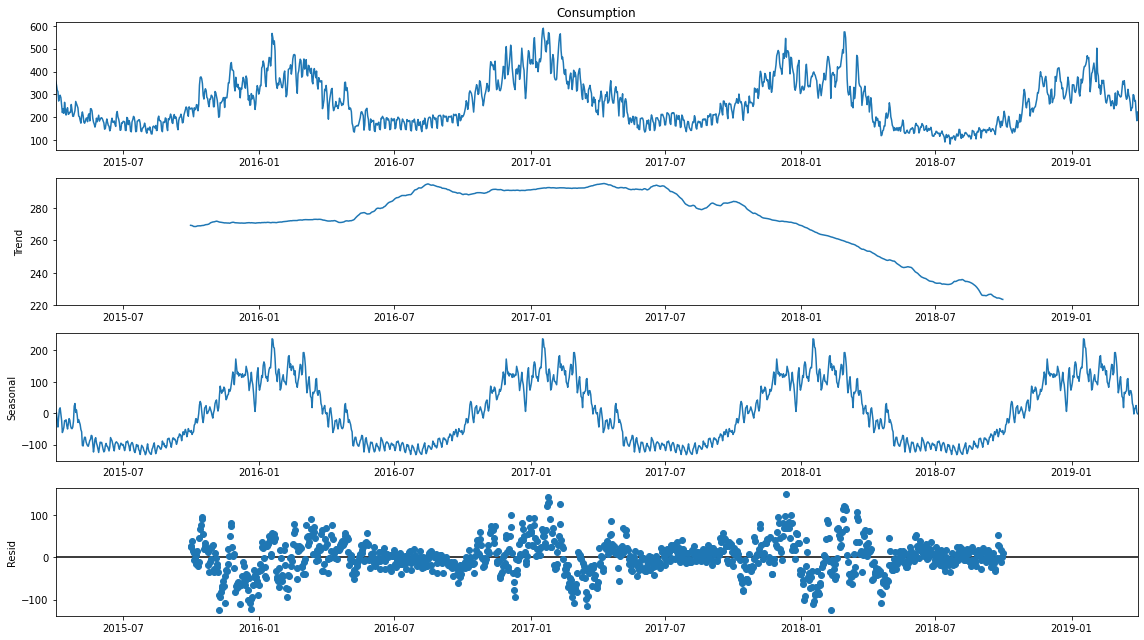

In [48]:
res = sm.tsa.seasonal_decompose(train.Consumption,period=365)
#s.seasonal.plot(figsize=(20,5))
fig = res.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()


* We see very strong yearly seasonality and repeating trend on an yearly basis for the last five years. 
* Generally it seesm there has been a slight decline leading up to Q1 2019. 

## Try fitting a ARIMAX/SARIMAX based model

In [51]:
auto_arima_model = auto_arima(y=train['Consumption'],
                              #x=exogenous_variable, #only required if exog data is used
                              #seasonal=True,
                              #m=365, #seasonality
                              information_criterion="aic",
                              trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13855.438, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14023.321, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14010.401, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13998.327, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14021.335, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13854.798, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13917.411, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13978.176, Time=0.50 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13855.027, Time=0.85 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=13856.188, Time=0.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13860.729, Time=0.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13857.449, Time=1.43 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=13852.815, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=13915.432, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0

In [53]:
#model=sm.tsa.statespace.SARIMAX(train['Consumption'],order=(1, 1, 2),seasonal_order=(1,1,1,12))
model=SARIMAX(train['Consumption'],order=(1, 1, 2),seasonal_order=(0,0,0,0))

#model = SARIMAX(endog=train['Consumption'],
#               # exog=exogenous_variable, #only required if exog data is used
#                order=auto_arima_model.order,
#                seasonal_order=auto_arima_model.seasonal_order)

model_fit=model.fit()
model_fit.summary()


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.08759D+00    |proj g|=  5.20517D-01

At iterate    5    f=  4.73885D+00    |proj g|=  4.91050D-03

At iterate   10    f=  4.73818D+00    |proj g|=  1.33296D-03

At iterate   15    f=  4.73814D+00    |proj g|=  2.14650D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     19      1     0     0   6.200D-06   4.738D+00
  F =   4.7381296483552306     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                 1461
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -6922.407
Date:                Wed, 07 Sep 2022   AIC                          13852.815
Time:                        20:57:09   BIC                          13873.960
Sample:                    04-01-2015   HQIC                         13860.703
                         - 03-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5327      0.041     13.127      0.000       0.453       0.612
ma.L1         -0.4771      0.042    -11.255      0.000      -0.560      -0.394
ma.L2         -0.3201      0.024    -13.180      0.000      -0.368      -0.273
sigma2       768.6943     19.839     38.746      0.000     729.810     807.579
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               292.61
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                            -0.03
Prob(H) (two-sided):                  0.06   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


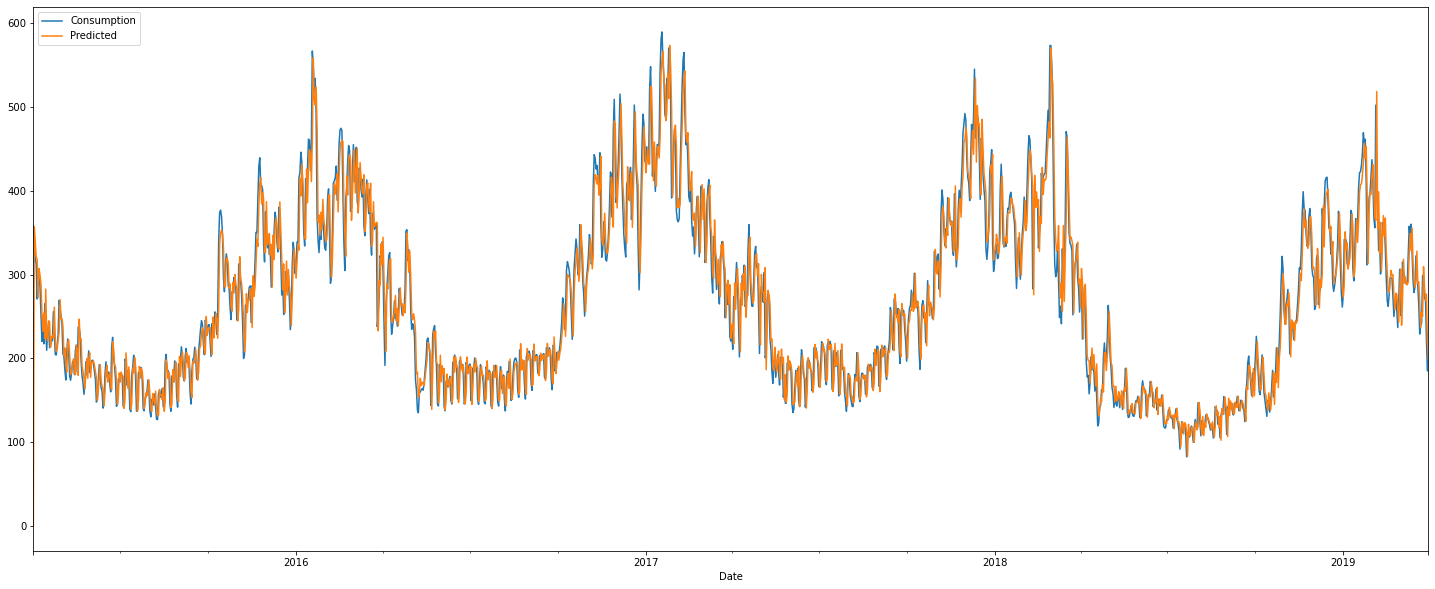

In [54]:
train['Consumption'].plot(figsize=(25,10))
train['Predicted'] = model_fit.fittedvalues
train['Predicted'].plot()
plt.legend(loc="upper left")



# Predict using testing sample

In [55]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,)
test['Predicted'] = predict.values
test['residual'] = abs(test['Consumption']-test['Predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (abs(test['residual'])/test['Consumption']).sum()*100/len(test)
print("MAE:", MAE)
print("MAPE:", MAPE)

MAE: 74.09536001771727
MAPE: 42.789541762951096


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


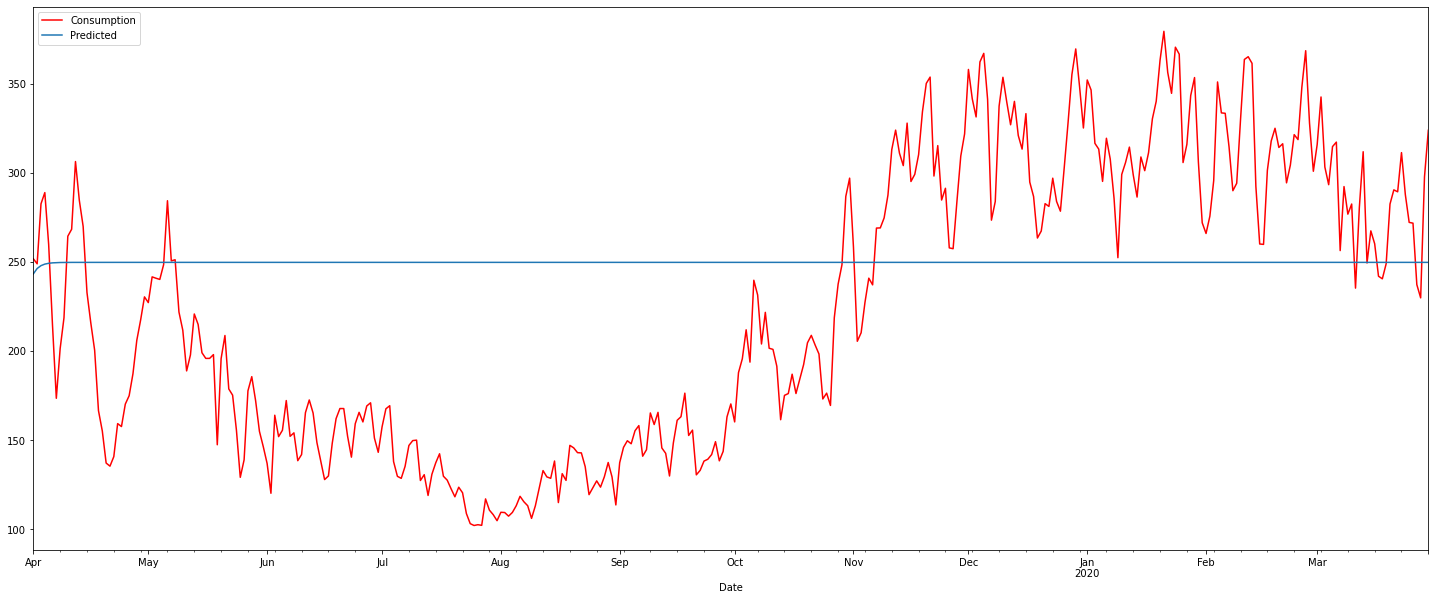

In [56]:
test['Consumption'].plot(figsize=(25,10),color = 'red')
test['Predicted'].plot()
plt.legend(loc="upper left")


* Predictions dont look too great. Need to encode strong seasonality better.


## Try using Machine learning for forecasts

In [57]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 7
                )

forecaster.fit(y=train['Consumption'])
forecaster 

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7] 
Window size: 7 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-04-01 00:00:00'), Timestamp('2019-03-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-09-07 20:57:28 
Last fit date: 2022-09-07 20:57:29 
Skforecast version: 0.4.3 

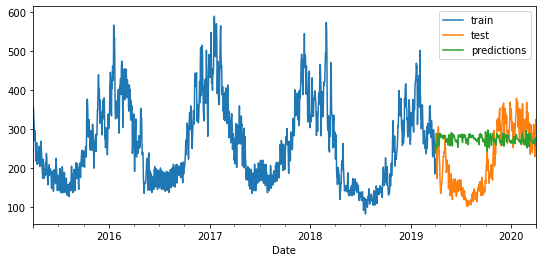

In [58]:
steps = 365
predictions = forecaster.predict(steps=steps)
predictions.head(5)

fig, ax = plt.subplots(figsize=(9, 4))
train['Consumption'].plot(ax=ax, label='train')
test['Consumption'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Optimise hyperparameters

In [61]:
steps = 365
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10,50]

# Regressor's hyperparameters
param_grid = {'n_estimators': [500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['Consumption'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 6


loop lags_grid: 100%|██████████████████████████████████████| 2/2 [04:02<00:00, 121.05s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 11036.643282995843



In [62]:
results_grid

,lags,params,metric,max_depth,n_estimators
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",11036.643283,5,500
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",11268.742365,10,500
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",11775.871582,5,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",11782.840122,10,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",15505.134733,3,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",15764.868958,3,500


## Forecast using best parameters

In [66]:
regressor = RandomForestRegressor(max_depth=5, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 50
             )

forecaster.fit(y=train['Consumption'])

Test error (mse): 7836.821483011414


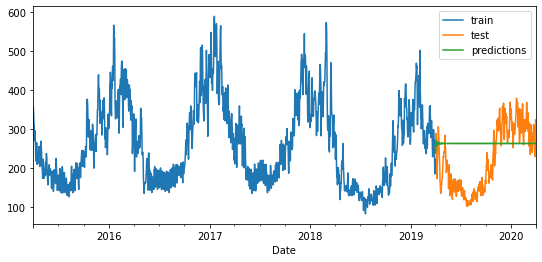

In [69]:
predictions = forecaster.predict(steps=365)
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
train['Consumption'].plot(ax=ax, label='train')
test['Consumption'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();
error_mse = mean_squared_error(
                y_true = test['Consumption'],
                y_pred = predictions
                )

print(f"Test error (mse): {error_mse}")


* Predictions don't look too great. Again need to encode strong historic seasonality better.
* Perhaps consider using a Fourier series as an exogenous variable in the ARIMAX model earlier.  


In [ ]:
# prepare Fourier terms
exog = pd.DataFrame({'date': df.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)
exog = exog.drop(columns=['date'])
exog_to_train = exog.iloc[:(len(df)-366)]
exog_to_test = exog.iloc[len(train):(len(df)-1)]
# Fit model
arima_exog_model = auto_arima(y=train['Consumption'], exogenous=exog_to_train, seasonal=True, m=7, information_criterion="aic",trace=True)

#train = df.iloc[0:(len(df)-366)]
#test = df.iloc[len(train):(len(df)-1)]

# Forecast
#y_arima_exog_forecast = arima_exog_model.predict(n_periods=365, exogenous=exog_to_test)

# Use Prophet forecasting

In [76]:
df_train  = train.copy(deep=True).reset_index()
df_train.rename(columns={'Date': 'ds','Consumption':'y'},inplace=True)

m = Prophet(daily_seasonality=True)
m.fit(df_train)


cmdstanpy  DEBUG input tempfile: /tmp/tmpvl_pa3in/m0g2bv_w.json
cmdstanpy  DEBUG input tempfile: /tmp/tmpvl_pa3in/0arnv77z.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['/opt/conda/lib/python3.7/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11484', 'data', 'file=/tmp/tmpvl_pa3in/m0g2bv_w.json', 'init=/tmp/tmpvl_pa3in/0arnv77z.json', 'output', 'file=/tmp/tmpzg_5ztdl/prophet_model-20220907215128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:51:28 - cmdstanpy - INFO - Chain [1] start processing
cmdstanpy  INFO  Chain [1] start processing
21:51:29 - cmdstanpy - INFO - Chain [1] done processing
cmdstanpy  INFO  Chain [1] done processing


In [77]:
future = m.make_future_dataframe(periods=365)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#fig1 = m.plot(forecast)
#fig2 = m.plot_components(forecast)


,ds,yhat,yhat_lower,yhat_upper
1821,2020-03-26,186.571687,132.423586,246.879514
1822,2020-03-27,177.053038,120.365166,231.502917
1823,2020-03-28,144.967332,91.364952,205.488227
1824,2020-03-29,138.486479,82.923538,189.762961
1825,2020-03-30,166.698200,109.331284,221.002702


Test error (mse): 3789.7607935486108


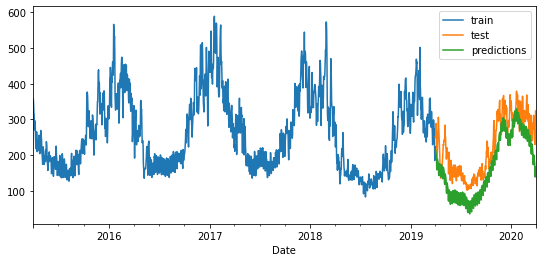

In [83]:
fig, ax = plt.subplots(figsize=(9, 4))

predictions = forecast[forecast['ds']>="2019-04-01"]['yhat']
predictions.index = test['Consumption'].index

train['Consumption'].plot(ax=ax, label='train')
test['Consumption'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();
error_mse = mean_squared_error(
                y_true = test['Consumption'],
                y_pred = predictions
                )

print(f"Test error (mse): {error_mse}")



* We have a much better fit on the testing data. Prophet tries to model the seasiality using a forier series as we clearly have a yearly 
seasonal trend repeated each year. 
* We can also encode the impact of bank holidays by adding in this as holiday periods in Prophet.

cmdstanpy  DEBUG input tempfile: /tmp/tmpvl_pa3in/0vpd3g_5.json
cmdstanpy  DEBUG input tempfile: /tmp/tmpvl_pa3in/n2rq1oin.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['/opt/conda/lib/python3.7/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19456', 'data', 'file=/tmp/tmpvl_pa3in/0vpd3g_5.json', 'init=/tmp/tmpvl_pa3in/n2rq1oin.json', 'output', 'file=/tmp/tmpvo1fdt2i/prophet_model-20220907221818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:18 - cmdstanpy - INFO - Chain [1] start processing
cmdstanpy  INFO  Chain [1] start processing
22:18:18 - cmdstanpy - INFO - Chain [1] done processing
cmdstanpy  INFO  Chain [1] done processing


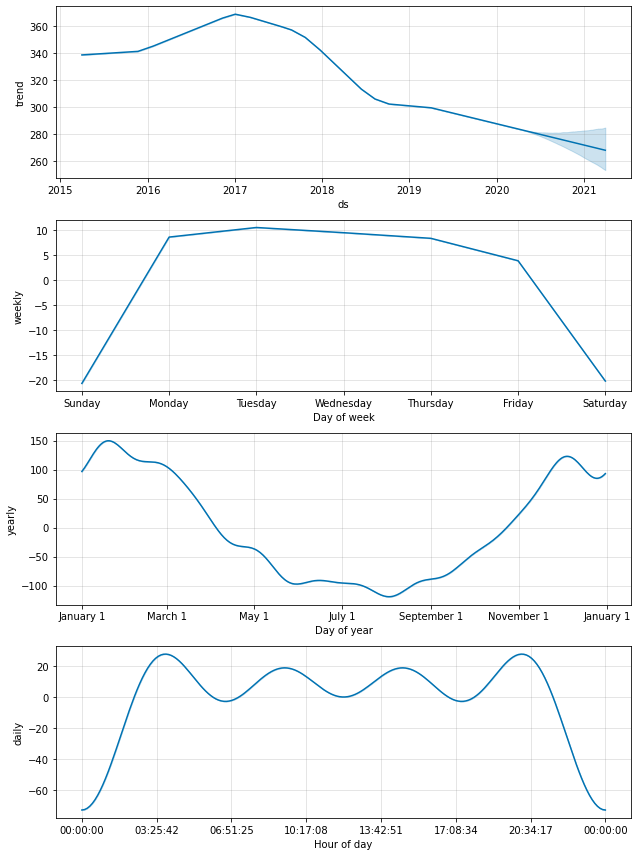

In [106]:
df_train  = train.copy(deep=True).reset_index()
df_test  = test.copy(deep=True).reset_index()
df_test_all = pd.concat([df_train,df_test],axis=0)

df_test_all.rename(columns={'Date': 'ds','Consumption':'y'},inplace=True)

m = Prophet(daily_seasonality=True)
m = m.fit(df_test_all)

future = m.make_future_dataframe(periods=365)
#future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig2 = m.plot_components(forecast)


## Plot forecast for next 365 days

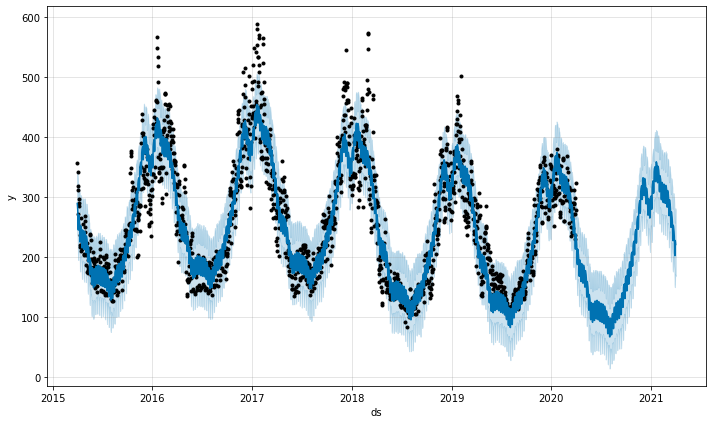

In [107]:
fig1 = m.plot(forecast)
